# Predicting Claim Denials and Reason Codes

Client is a US based <b>R</b>evenue <b>C</b>ycle <b>M</b>anagement<b>(RCM)</b> company. On an average, they experience about 10% of the claims getting completely denied. This results in a huge manual re-work on those denied claims. 

### Business Challenge

- In healthcare, a lot of rework is done due to claim denials. The reason being the denials dependent on multiple factors which are difficult to identify manually.
- Client wanted a solution  which predicts the likelihood of a claim getting denied.
- Client also needed to identify the causes of denials for the claims getting denied.

### Benefits

- Saved the client from re-work on denied claims.
- The solution helped in reducing cost required to manually perform the process. It also saved a lot of time
- Predicting reasons for rejection allowed client to make corrections in the denied claims and resubmit for a better approval rate.


In [81]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
pd.get_option("display.max_columns",None)
%matplotlib inline
sns.set(color_codes=True)
warnings.filterwarnings('ignore')
palette = {'Fully Denied':'red','Fully Paid':'green','Partially Denied':'yellow'}

In [82]:
data = pd.read_csv("claims_preprocessed.csv")
data.columns

Index(['Unnamed: 0', 'member_id', 'subscriber_id', 'city', 'county',
       'provider_id', 'provider_type', 'provider_type2', 'claim_id',
       'claim_sequence', 'line_of_business', 'age', 'gender', 'claim_sub_type',
       'network_indicator1', 'place_of_service', 'procedure_code',
       'diagnosis_code', 'claim_from_date', 'claim_to_date', 'amount_on_claim',
       'amount_considered', 'amount_allowed', 'amount_dis_allowed',
       'amount_paid', 'dedcutible', 'copay', 'coinsurance', 'rejection_code',
       'rejection_reason', 'network_indicator2', 'pre_auth_indicator',
       'status', 'combination_id', 'ICD_10'],
      dtype='object')

In [83]:
provider_type = {'F':'Facility','G':'Provider Group','I':'IPA','P':'Practioner'}
claim_sub_type = {'H':'Hospital','M':'Medical'}
network_indicator1 = {'P':'Participating','I':'In Network','O':'Out of Network'}
status = {'FD':"Fully Denied", 'PD':"Partially Denied", 'FP':"Fully Paid"}
pre_auth_indicator = {'N':'Not Required','F':'Found','V':'Violated'}
place_of_service = {'99.0':'Other Unlisted Facility','11.0':'Office','20.0':'Urgent Care Facility','21.0':'Inpatient Hospital',
                   '12.0':'Patients Office','81.0':'Independent Laboratory','22.0':'Outpatient Hospital'}

In [84]:
data['provider_type'] = data['provider_type'].apply(lambda x :provider_type.get(x,x))
data['claim_sub_type'] = data['claim_sub_type'].apply(lambda x :claim_sub_type.get(x,x))
data['network_indicator1'] = data['network_indicator1'].apply(lambda x :network_indicator1.get(x,x))
data['network_indicator2'] = data['network_indicator2'].apply(lambda x :network_indicator1.get(x,x))
data['status'] = data['status'].apply(lambda x :status.get(x,x))
data['pre_auth_indicator'] = data['pre_auth_indicator'].apply(lambda x :pre_auth_indicator.get(x,x))
data['place_of_service'] = data['place_of_service'].apply(lambda x :place_of_service.get(x,x))

In [86]:
data = data.iloc[:,1:]
data

,subscriber_id,city,county,provider_id,provider_type,provider_type2,claim_id,claim_sequence,line_of_business,age,...,dedcutible,copay,coinsurance,rejection_code,rejection_reason,network_indicator2,pre_auth_indicator,status,combination_id,ICD_10
0,s21835,B1,D1,NaN,Facility,HOSP,c7946,1,Medicaid,25,...,0.0,0.0,0.0,500,Disallowed amount,Participating,Not Required,Fully Denied,c7946_1,M00-M99
1,s21835,B1,D1,NaN,Facility,HOSP,c7946,2,Medicaid,25,...,0.0,0.0,0.0,500,Disallowed amount,Participating,Not Required,Fully Denied,c7946_2,M00-M99
2,s21836,Others,Others,p349,Facility,HOSP,c7947,1,Medicaid,22,...,0.0,0.0,0.0,CDD,Claim is a duplicate of a previously submitted...,Participating,Not Required,Fully Denied,c7947_1,A00-B99
3,s21837,B3,D3,NaN,Facility,HOSP,c7948,1,Medicaid,55,...,0.0,0.0,0.0,K03,APC/APG Pricing Never Pay,Participating,Not Required,Fully Denied,c7948_1,H60-H95
4,s21838,B3,D4,NaN,Facility,HOSP,c7949,1,Medicaid,63,...,0.0,0.0,0.0,K02,APC/APG Pricing Stand Alone,Participating,Not Required,Fully Denied,c7949_1,I00-I95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876466,s188497,B8,D9,p6400,Facility,HOSP,c275119,5,Medicaid,27,...,0.0,0.0,0.0,E01,EAPG Pricing Full Payment,NaN,Not Required,Partially Denied,c275119_5,M00-M99
876467,s188497,B8,D9,p6400,Facility,HOSP,c275119,4,Medicaid,27,...,0.0,0.0,0.0,E01,EAPG Pricing Full Payment,NaN,Not Required,Partially Denied,c275119_4,M00-M99
876468,s188497,B8,D9,p6400,Facility,HOSP,c275119,1,Medicaid,27,...,0.0,0.0,0.0,E04,EAPG Pricing Packaged,NaN,Not Required,Partially Denied,c275119_1,M00-M99
876469,s188497,B8,D9,p6400,Facility,HOSP,c275119,3,Medicaid,27,...,0.0,0.0,0.0,E01,EAPG Pricing Full Payment,NaN,Not Required,Partially Denied,c275119_3,M00-M99


<h1 style = "color : darkblue">Claim Status</h1>
<h3 style="color:hotpink">There are 3 Types of claim status </h3>
<ol>
    <li>FD : Fully Denied
    <li>FP : Fully Paid
    <li>PD : Partially Denied
</ol>

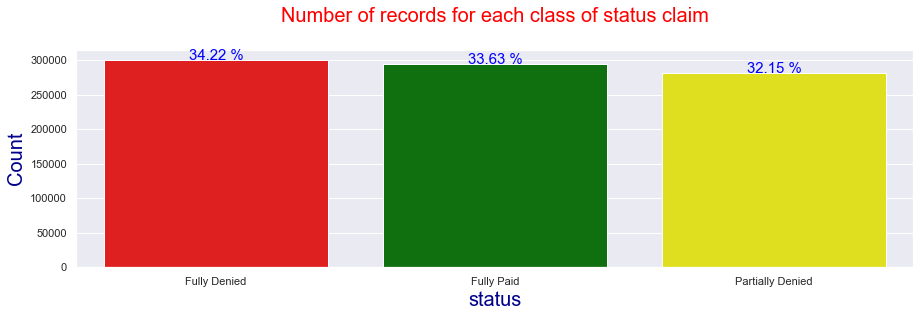

In [6]:
palette = {'Fully Denied':'red','Fully Paid':'green','Partially Denied':'yellow'}
feature = 'status'
staus_counts = dict(data[feature].value_counts())
total = sum(staus_counts.values())
plt.figure(figsize =(15,4))
p = sns.countplot(x = feature,data=data,palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title('Number of records for each class of status claim', color='red',fontsize =20,y =1.1)
for index,bar in enumerate(staus_counts):
     p.text(index,staus_counts[bar], f'{round(staus_counts[bar]*100/total,2)} %', color='blue',fontsize=15, ha="center")
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>All the 3 classes have almost equal amount of data.
</ol>

<h1 style = "color : darkblue">City</h1>

Text(0.5, 1.1, 'Number of records for each class of city')

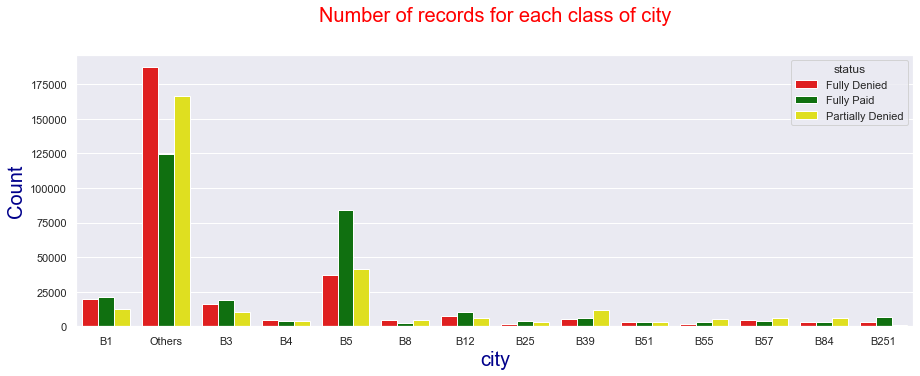

In [7]:
feature = 'city'
plt.figure(figsize =(15,5))
ax = sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)

<h3 style="color:green">Inferences</h3>
<ol>
    <li>If it is B5, the chances are too high for getting fully paid in comparision to the fully denied or partially denied.
    <li>But this field got "Others" as category which represents a group of other cities. So when testing on new data, the low probable city may be given high importance as it will be put under this others category.
</ol>

<h1 style = "color : darkblue">County</h1><br>
A sub geogrophial region with in the state

Text(0.5, 1.1, 'Number of records for each class of county')

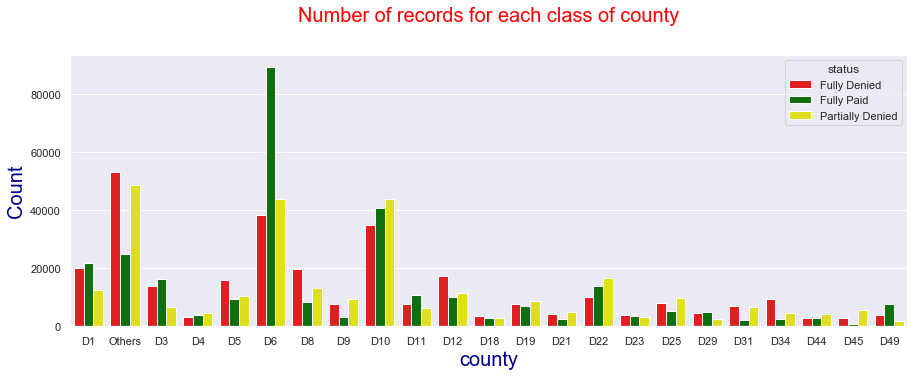

In [8]:
feature = 'county'
plt.figure(figsize =(15,5))
ax = sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)

<h3 style="color:green">Inferences</h3>
<ol>
    <li>If it is D6, the chances are too high for getting fully paid in comparision to the fully denied or partially denied.
    <li>But this field got "Others" as category which represents a group of other counties. So when testing on new data, the low probable county may be given high importance as it will be put under this others category.
</ol>

<h1 style = "color : darkblue">Provider Type</h1>
<h3 style="color:hotpink">There are 2 Types of Providers </h3>
<ol>
    <li>F : Facility
    <li>P : Practioner
</ol>

Text(0.5, 1.1, 'Number of records for each class of provider_type')

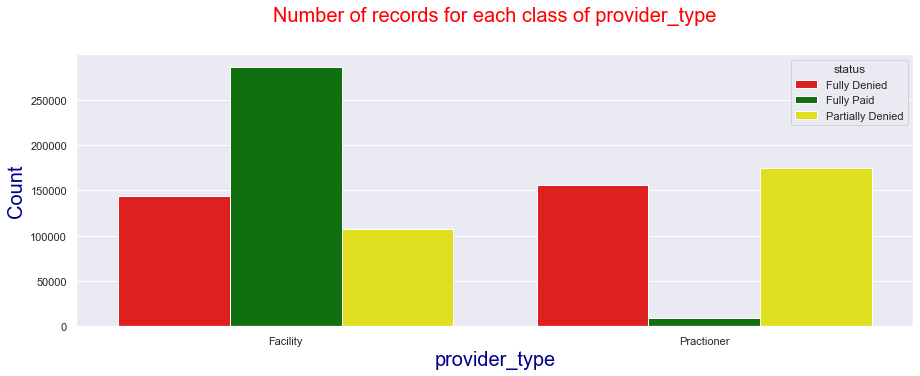

In [9]:
feature = 'provider_type'
plt.figure(figsize =(15,5))
ax = sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)

<h3 style="color:green">Inferences</h3>
<ol>
    <li>When provider is a Practioner, the chances of getting fully paid is very low.
    <li>When Provider is a Facility, the chances of getting fully paid is very high.
</ol>

<h1 style = "color : darkblue">Provider Type 2</h1>

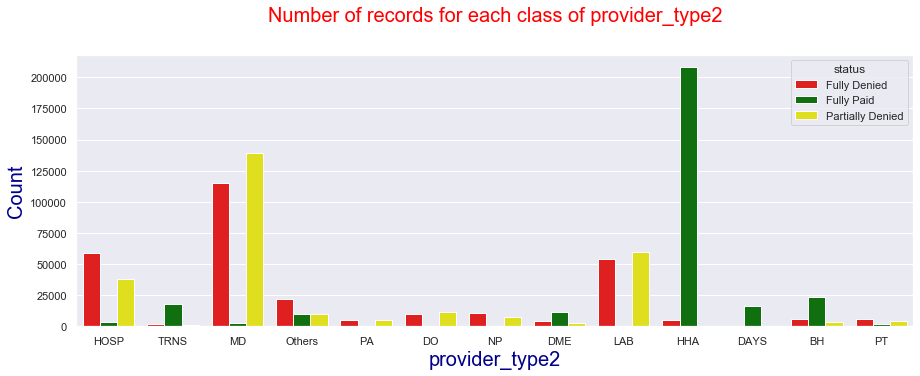

In [10]:
feature = 'provider_type2'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>If it is HHA, the chances are too high for getting fully paid
    <li>If it is MD or HOSP or LAB , the chances are too high for getting denied or partially denied
</ol>

<h1 style = "color : darkblue">Claim Sequence</h1><br>
<b>This number indiactes how many times a member has been given any of the medical services and claim request has been raised by the provider</b>


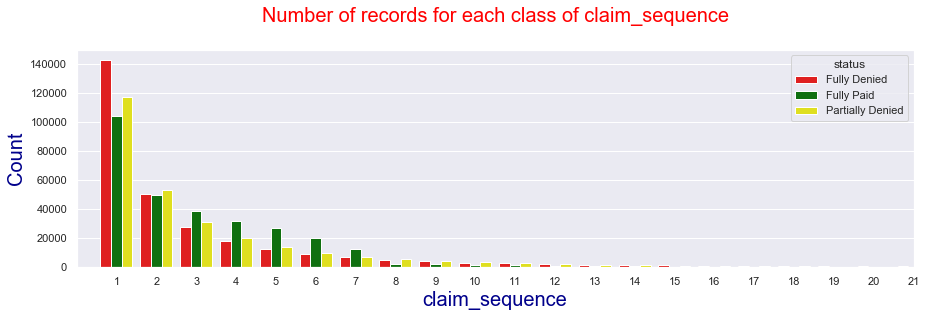

In [11]:
feature = 'claim_sequence'
plt.figure(figsize =(15,4))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.xlim(-1,20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>As there will not be any restrictions on numbers of visits, this field does not crete any impact
</ol>

<h1 style = "color : darkblue">Line of Buisiness</h1>
<h3 style="color:hotpink">There are 3 Types of Insurance Providers </h3>
<ol>
    <li>F : <b>Medicaid</b> is a federal program that provides health coverage if you are 65+ or under 65 and have a disability, no matter your income.
    <li>P : <b>Medicare</b> is a state and federal program that provides health coverage if you have a very low income.
    <li>P : <b>Commercial Plan</b> It is a private organisational plan
</ol>

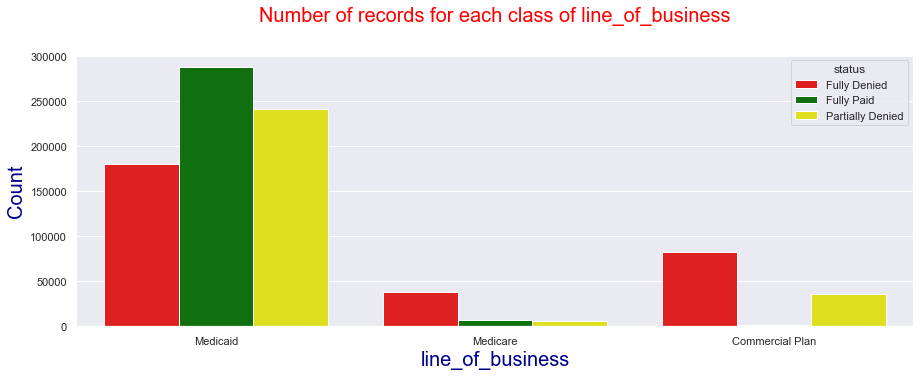

In [12]:
feature = 'line_of_business'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>It is cleary eident that most of the members are taking Medicaid as it is for low income people
    <li>If it is a commercial plan, the chances of getting Fully Paid is almost zero.
</ol>

<h1 style = "color : darkblue">Age</h1>

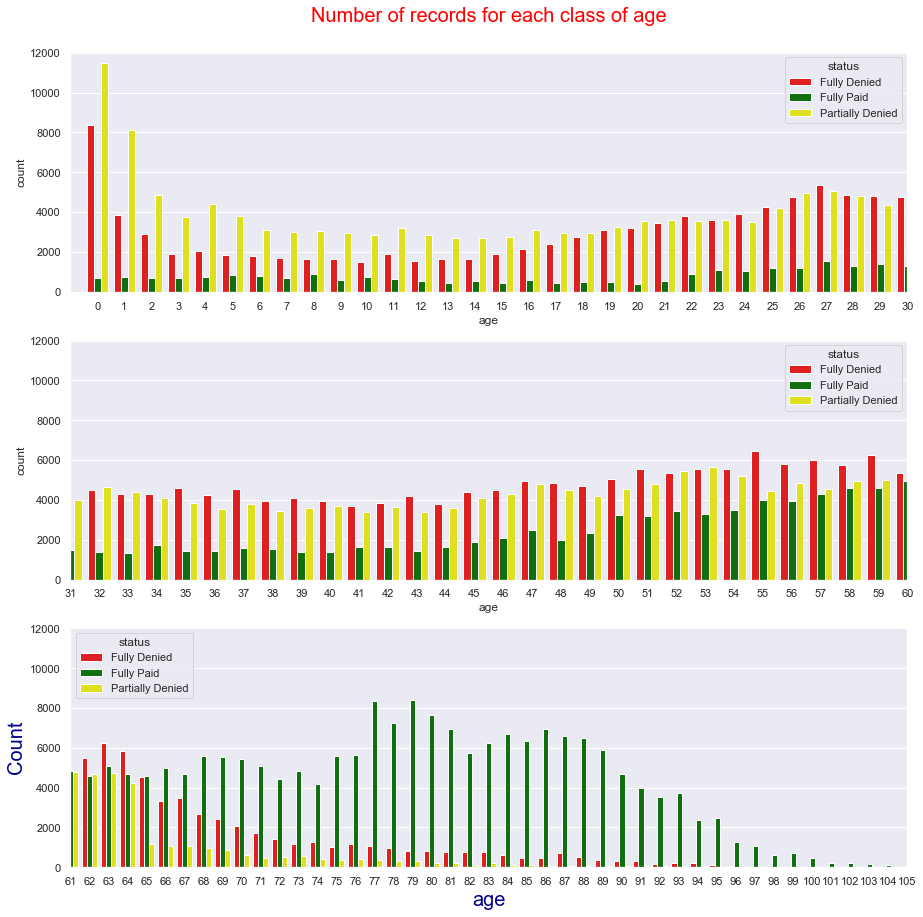

In [13]:
feature = 'age'
plt.figure(figsize =(15,15))
plt.subplot(311)
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlim(-1,30)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.subplot(312)
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlim(31,60)
plt.subplot(313)
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlim(61,105)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>As age increases the chances of gettig fully paid also increase
    <li>When age is very less chances of getting denied or partially paid is too high
</ol>

<h1 style = "color : darkblue">Gender</h1>


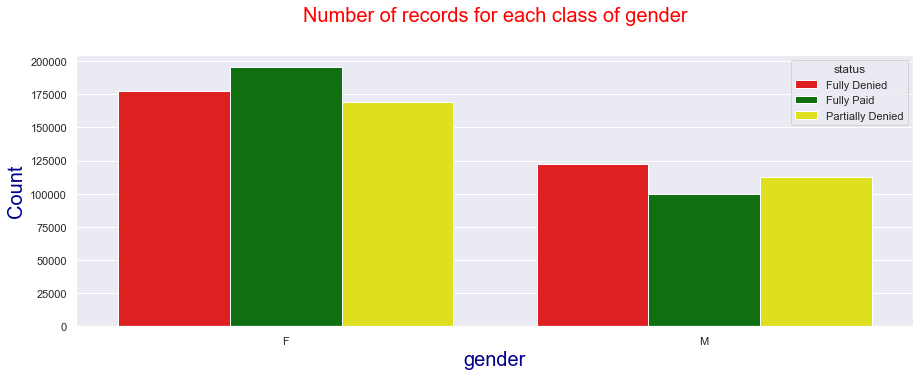

In [14]:
feature = 'gender'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>Gender does not have much impact on claim status.But Female has slight advantgae it seems
</ol>

<h1 style = "color : darkblue">Claim Sub Type</h1>
<h3 style="color:hotpink">There are 2 Types of Claims </h3>
<ol>
    <li>H : <b>Hospital</b>Where both in and out patients are allowed
    <li>M : <b>Medicare</b>Where only out patients are allowed
</ol>

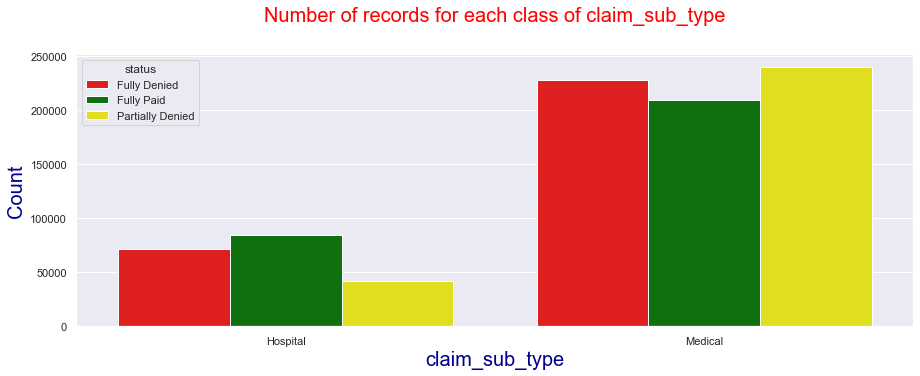

In [15]:
feature = 'claim_sub_type'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>As most of the people prefer Medical so data is biased towards it.
    <li>There is no much difference in claim status for both the claim types
</ol>

<h1 style = "color : darkblue">Network Indicator</h1>
<h3 style="color:hotpink">There are 3 Types of Network Indicators </h3>
<ol>
    <li>I : <b>In Network</b> Which is available in the listed health organisations
    <li>O : <b>Out of Network</b> Which is not available in the listed health organisations
    <li>P : <b>Participating</b> Which does not have direct relationship with the insurance compnaies but can be referred by a listed one
</ol>

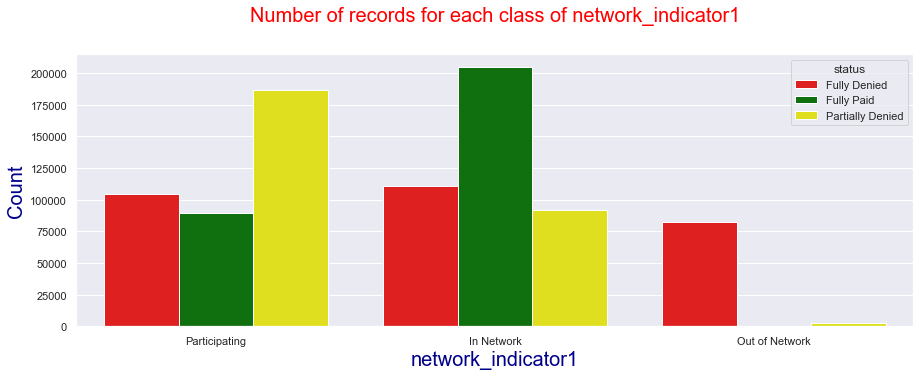

In [16]:
feature = 'network_indicator1'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>If it is out of network then chances are zero for getting paid and rejection rate is too high
    <li>If it is in network then chances of getting paid fuly is high
    <li>If it is a participating one then chances of getting partially denied is high
</ol>

<h1 style = "color : darkblue">Place of Service</h1>

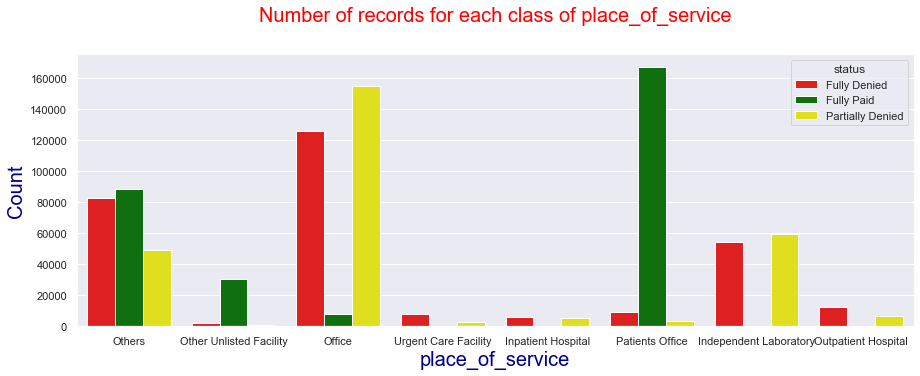

In [17]:
feature = 'place_of_service'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>If the service is provided at Patients office, the chances of getting fully paid is too high.
    <li>If it is office, the chances are too low for getting full amount.
</ol>

<h1 style = "color : darkblue">Amount on Claim</h1>

In [18]:
# 0 to 90 percentiles
for i in range(0,91,10):
    print(f'The {i} th Percentile : {np.percentile(data.amount_on_claim,i)}')

The 0 th Percentile : 0.0
The 10 th Percentile : 17.85
The 20 th Percentile : 35.0
The 30 th Percentile : 52.0
The 40 th Percentile : 74.0
The 50 th Percentile : 93.29
The 60 th Percentile : 115.0
The 70 th Percentile : 150.0
The 80 th Percentile : 200.0
The 90 th Percentile : 300.0


In [19]:
# 90 to 100 percentiles
for i in range(90,101):
    print(f'The {i} th Percentile : {np.percentile(data.amount_on_claim,i)}')

The 90 th Percentile : 300.0
The 91 th Percentile : 333.0
The 92 th Percentile : 373.75
The 93 th Percentile : 408.0
The 94 th Percentile : 450.0
The 95 th Percentile : 508.0
The 96 th Percentile : 626.0
The 97 th Percentile : 810.0
The 98 th Percentile : 1200.0
The 99 th Percentile : 2216.66
The 100 th Percentile : 49964.82


In [20]:
data= data[data.amount_on_claim<=1000]

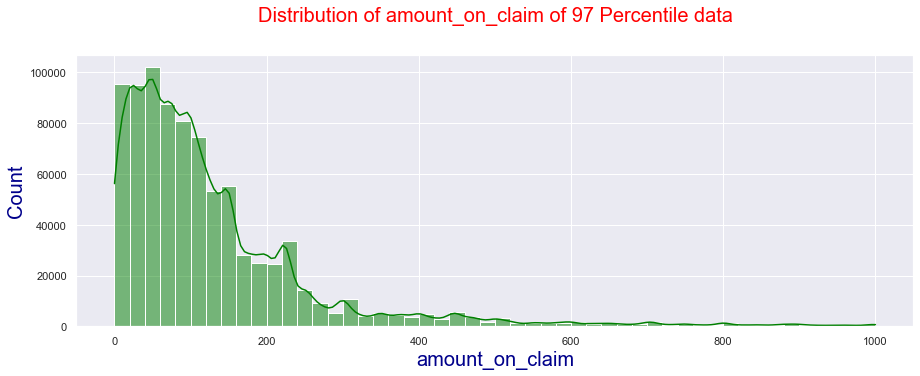

In [21]:
feature = 'amount_on_claim'
plt.figure(figsize =(15,5))
sns.histplot(x =feature,data=data,bins = 50,kde=True,color ='green')
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Distribution of amount_on_claim of 97 Percentile data', color='red',fontsize =20,y =1.1)
plt.show()

In [1]:
feature = 'amount_on_claim'
plt.figure(figsize =(15,5))
sns.histplot(x =feature,data=data,bins = 50,kde=True,hue='status',
             palette = palette,)
#              element="step",stat="density")
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Distribution of amount_on_claim of 97 Percentile data class wise', color='red',fontsize =20,y =1.1)
plt.show()

NameError: name 'plt' is not defined

<h3 style="color:green">Inferences</h3>
<ol>
    <li>This field has got outliers as 97 perentile value is around 800 and the max is 49000. so a cap is put at 1000 and other records got removed.
</ol>

<h1 style = "color : darkblue">Pre Authorization Indicator</h1><br>
<b>Some insurance companies ask pre authorization request from providers before admitting the Patients for some kinds of treatments</b>

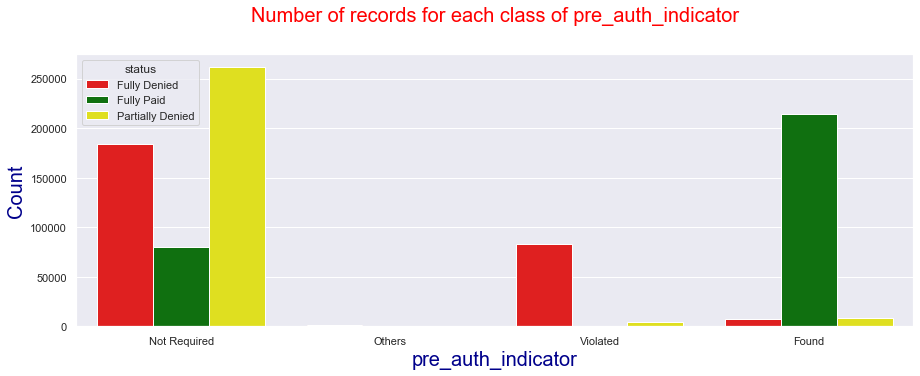

In [23]:
feature = 'pre_auth_indicator'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>It is evident that when pre authorization approval is found, the chances are too high for getting fully paid
    <li>If it is not found when it is required, the chances are too high for getting denied treating it as violated
    <li>If it is not required then then chances are more for getting partially denied followed by fully denied.
</ol>

<h1 style = "color : darkblue">ICD_10</h1><br>
<b>The diagnosis_code column contanis around more than 10k unique fields. So it is grouped into 21 categories based on initials <b/>

<table border="1">
        <tbody>
          <tr>
            <th>Range</th>
            <th>Topic</th>
          </tr>
          <tr>
            <td>A00-B99</td>
            <td>Certain infections and parasitic diseases</td>
          </tr>
          <tr>
            <td>C00-D49</td>
            <td>Neoplasms</td>
          </tr>
          <tr>
            <td>D50-D89</td>
            <td>Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism</td>
          </tr>
          <tr>
            <td>E00-E89</td>
            <td>Endocrine, nutritional and metabolic diseases</td>
          </tr>
          <tr>
            <td>F01-F99</td>
            <td>Mental, Behavioral and Neurodevelopmental disorders</td>
          </tr>
          <tr>
            <td>G00-G99</td>
            <td>Diseases of the nervous system</td>
          </tr>
          <tr>
            <td>H00-H59</td>
            <td>Diseases of the eye and adnexa</td>
          </tr>
          <tr>
            <td>H60-H95</td>
            <td>Diseases of the ear and mastoid process</td>
          </tr>
          <tr>
            <td>I00-I99</td>
            <td>Diseases of the circulatory system</td>
          </tr>
          <tr>
            <td>J00-J99</td>
            <td>Diseases of the respiratory system</td>
          </tr>
          <tr>
            <td>K00-K95</td>
            <td>Diseases of the digestive system</td>
          </tr>
          <tr>
            <td>L00-L99</td>
            <td>Diseases of the skin and subcutaneous tissue</td>
          </tr>
          <tr>
            <td>M00-M99</td>
            <td>Diseases of the musculoskeletal system and connective tissue</td>
          </tr>
          <tr>
            <td>N00-N99</td>
            <td>Diseases of the genitourinary system</td>
          </tr>
          <tr>
            <td>O00- O9A</td>
            <td>Pregnancy, childbirth, and puerperium</td>
          </tr>
          <tr>
            <td>P00-P96</td>
            <td>Certain conditions originating in the perinatal period</td>
          </tr>
          <tr>
            <td>Q00-Q99</td>
            <td>Congenital malformations, deformations and chromosomal abnormalities</td>
          </tr>
          <tr>
            <td>R00-R99</td>
            <td>Symptoms, signs, and abnormal clinical laboratory findings, not elsewhere classified</td>
          </tr>
          <tr>
            <td>S00-T88</td>
            <td>Injury, poisoning, and certain other consequences of external causes</td>
          </tr>
          <tr>
            <td>V00-Y99</td>
            <td>External causes of morbidity</td>
          </tr>
          <tr>
            <td>Z00-Z99</td>
            <td>Factors influencing health status and contact with health services</td>
          </tr>
        </tbody>
      </table>

In [99]:
data['ICD_10']='Other'
data.loc[data.diagnosis_code.str.contains('^A'), 'ICD_10'] = 'Parasitic_diseases'
data.loc[data.diagnosis_code.str.contains('^B'), 'ICD_10'] = 'Parasitic_diseases'
data.loc[data.diagnosis_code.str.contains('^C'), 'ICD_10'] = 'Neoplasms'
data.loc[data.diagnosis_code.str.contains('^D[0-4]'), 'ICD_10'] = 'Neoplasms'
data.loc[data.diagnosis_code.str.contains('^D[5-8]'), 'ICD_10'] = 'Blood_diseases'
data.loc[data.diagnosis_code.str.contains('^E'), 'ICD_10'] = 'Metabolic diseases'
data.loc[data.diagnosis_code.str.contains('^F'), 'ICD_10'] = 'Neurodevelopmental_disorders'
data.loc[data.diagnosis_code.str.contains('^G'), 'ICD_10'] = 'Nervous_diseases'
data.loc[data.diagnosis_code.str.contains('^H[0-5]'), 'ICD_10'] = 'Eye_diseases'
data.loc[data.diagnosis_code.str.contains('^H[6-9]'), 'ICD_10'] = 'Ear_diseases'
data.loc[data.diagnosis_code.str.contains('^I'), 'ICD_10'] = 'Circulatory_diseases'
data.loc[data.diagnosis_code.str.contains('^J'), 'ICD_10'] = 'Respiratory_diseases'
data.loc[data.diagnosis_code.str.contains('^K'), 'ICD_10'] = 'Digestive_diseases'
data.loc[data.diagnosis_code.str.contains('^L'), 'ICD_10'] = 'Skin_diseases'
data.loc[data.diagnosis_code.str.contains('^M'), 'ICD_10'] = 'Musculoskeletal_diseases'
data.loc[data.diagnosis_code.str.contains('^N'), 'ICD_10'] = 'Genitourinary_diseases'
data.loc[data.diagnosis_code.str.contains('^O'), 'ICD_10'] = 'Pregnancy_childbirth'
data.loc[data.diagnosis_code.str.contains('^P'), 'ICD_10'] = 'Perinatal_period'
data.loc[data.diagnosis_code.str.contains('^Q'), 'ICD_10'] = 'Chromosomal_abnormalities'
data.loc[data.diagnosis_code.str.contains('^R'), 'ICD_10'] = 'Abnormal_findings'
data.loc[data.diagnosis_code.str.contains('^S'), 'ICD_10'] = 'Injury_poisining'
data.loc[data.diagnosis_code.str.contains('^T'), 'ICD_10'] = 'Injury_poisining'
data.loc[data.diagnosis_code.str.contains('^V'), 'ICD_10'] = 'External_causes'
data.loc[data.diagnosis_code.str.contains('^W'), 'ICD_10'] = 'External_causes'
data.loc[data.diagnosis_code.str.contains('^X'), 'ICD_10'] = 'External_causes'
data.loc[data.diagnosis_code.str.contains('^Y'), 'ICD_10'] = 'External_causes'
data.loc[data.diagnosis_code.str.contains('^Z'), 'ICD_10'] = 'Health_services'

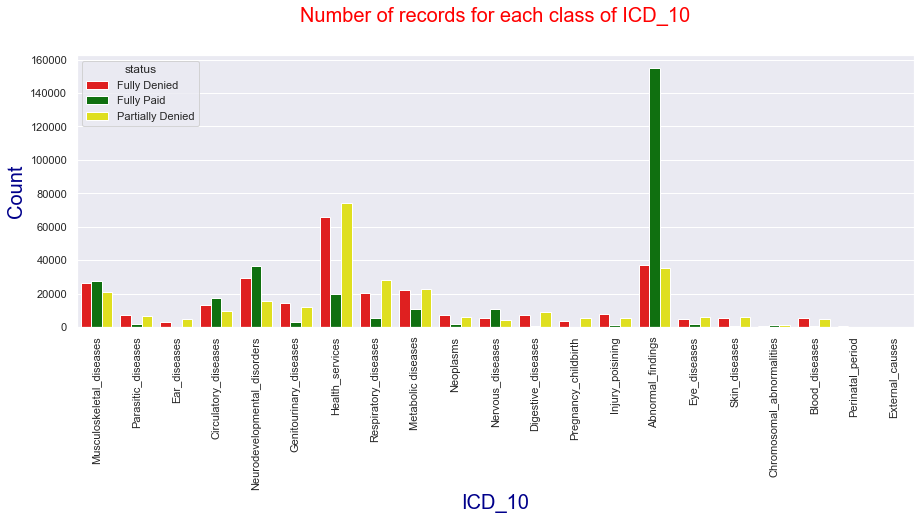

In [100]:
feature = 'ICD_10'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette = palette)
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.xticks(rotation = 90)
plt.show()

<h3 style="color:green">Inferences</h3>
<ol>
    <li>The ICD codes that start with R (abnormal clinical laboratory findings) have got high chances of getting full amount in comparision to others
    <li>The ICD codes that starts with Z (Factors influencing health status) have got high chances of getting denied or getting partially denied
</ol>

<h1 style = "color : darkblue">Other Redundant Features</h1>
<ol style = "color : red">
    <li>member_id
    <li>subscriber_id
    <li>provider_id
    <li>claim_id
    <li>claim_sequence
    <li>amount_considered
    <li>amount_allowed
    <li>amount_dis_allowed
    <li>amount_paid
    <li>dedcutible
    <li>copay
    <li>coinsurance
    <li>combination_id
    <li>network_indicator2
    <li>rejection_code
    <li>rejection_reason
</ol>

<h1 style = "color : darkblue">Feature Engineering</h1><br>

<h1 style = "color : darkblue">Grouped Procedure Code</h1>
<h3 style = "color : green">As we got more 10k procedure codes, we can group them based on some domain knowledge</h3>

<h1 style = "color : darkblue">CPT Codes</h1>
<h2>Understanding the Types of CPT<sup>®</sup> Codes</h2>

<ul>
        <li><strong>CPT<sup>®</sup> Category I</strong> —the largest body of codes consisting of those commonly used by providers to report their services and procedures</li>
        <li><strong>CPT<sup>®</sup> Category II</strong> —supplemental tracking codes used for performance management</li>
        <li><strong>CPT<sup>®</sup> Category III</strong> —temporary codes used to report emerging and experimental services and procedures</li>

</ul>

<h4><strong>Category I codes :</strong></h4>

<ol style="list-style-type: 1">
        <li>Evaluation &amp; Management Services (99202 – 99499)</li>
        <li>Anesthesia Services (01000 – 01999)</li>
        <li>Surgery (10021 – 69990) – further broken into body area or system within this code range</li>
        <li>Radiology Services (70010 – 79999)</li>
        <li>Pathology and Laboratory Services (80047 – 89398)</li>
        <li>Medical Services and Procedures (90281 – 99607)</li>
    </ol>
<h4><strong>Category II codes :</strong></h4>

<ol>
        <li>Composite Measures (0001F – 0015F)</li>
        <li>Patient Management (0500F – 0584F)</li>
        <li>Patient History (1000F – 1505F)</li>
        <li>Physical Examination (2000F – 2060F)</li>
        <li>Diagnostic/Screening Processes or Results (3006F – 3776F)</li>
        <li>Therapeutic, Preventive, or Other Interventions (4000F – 4563F)</li>
        <li>Follow-up or Other Outcomes (5005F – 5250F)</li>
        <li>Patient Safety (6005F – 6150F)</li>
        <li>Structural Measures (7010F – 7025F)</li>
        <li>Nonmeasure Code Listing (9001F – 9007F)</li>

</ol>
<h4><strong>Category III codes :</strong></h4>
<p>
Category III codes, depicted with four numbers and the letter T, follow Category II codes in the coding manual. These are temporary codes that represent new technologies, services, and procedures.
</p>
<h2>List of all CPT Modifiers</h2>
<ol><li><strong>Level I CPT</strong> <strong>Modifiers</strong>: Normally known as CPT Modifiers and consists of two numeric digits and are updated annually by AMA – American Medical Association.<br></li><li><strong>Level II HCPCS</strong> <strong>Modifiers: </strong>Normally known as <a href="https://www.codingahead.com/new-hcpcs-modifiers-effective-from-jan-html/">HCPCS Modifiers</a> and consists of two digits (Alpha / Alphanumeric characters) in the sequence AA through VP. These modifiers are annually updated by CMS – Centres for Medicare and Medicaid Services.</li></ol>

<h5>When medical coders and billers talk about HCPCS codes, they're referring to HCPCS Level II codes. When they talk about CPT® coding, they’re actually referring to HCPCS Level I.</h5>

https://www.aapc.com/resources/medical-coding/hcpcs.aspx

In [29]:
hcpcs_data = pd.read_csv("hcpcs_data.csv")
hcpcs_data

,Description,Group Code
0,Ambulance and Other Transport Services and Sup...,A0021-A0999
1,Medical And Surgical Suppliess,A4206-A8004
2,"Administrative, Miscellaneous and Investigational",A9150-A9999
3,Enteral and Parenteral Therapy,B4034-B9999
4,Outpatient PPS,C1713-C9899
5,Durable Medical Equipment,E0100-E8002
6,Procedures / Professional Services,G0008-G9987
7,Alcohol and Drug Abuse Treatment,H0001-H2037
8,Drugs Administered Other than Oral Method,J0120-J8999
9,Chemotherapy Drugs,J9000-J9999


<table>
<tbody><tr>
<th valign="top"><p class="web_normal">Type of modifier</p></th>
<th valign="top"><p class="web_normal">Modifiers listed</p></th></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144506. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144506" target="_top">Additional HCPCS modifiers</a></p></td>
<td valign="top"><p class="web_normal">AE, AF, AG, AI, AK, AM, AO, AT, AZ, BL, CA, CB, CG, CR, CS, CT, DA, ER, ET, FB, FC, FX, FY, G7, GC, GE, GG, GJ, GU, J1, J2, J3, JC, JC, JD, JG, JW, KX, L1, M2, PD, PI, PO, PN, PS, PT, Q0, Q1, Q3, Q4, Q5, Q6, QQ, RD, RE, SC, SF, SS, SW, TB, TC, TS, UJ, UN, UP, UQ, UR, US, X1, X2, X3, X4, X5, XE, XP, XS, XU, ZA, ZB, ZC</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144508. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144508" target="_top">Advance beneficiary notice of noncoverage (ABN) modifiers</a></p></td>
<td valign="top"><p class="web_normal">GA, GX, GY, GZ</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00219903. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00219903" target="_top">Advanced diagnostic imaging appropriate use modifiers</a></p></td>
<td valign="top"><p class="web_normal">MA, MB, MC, MD, ME, MF, MG, MG, MH, QQ</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144505. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144505" target="_top">Ambulance modifiers</a></p></td>
<td valign="top"><p class="web_normal">D, E, G, H, I, J, N, P, R, S, X, GM, QL, QM, QN</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144519. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144519" target="_top">Anatomical modifiers</a> <br>
(coronary artery, eye lid, finger, side of body, toe)</p></td>
<td valign="top"><p class="web_normal">E1, E2, E3, E4, FA,F1,F2,F4, F5, F6, F7, F8, F9, LC, LD, LM, LT, RC, RI, RT, TA, T1, T2, T3, T4, T5, T6, T7, T8, T9</p><p class="web_normal"><span class="web_bold">Note:</span> If the anatomical modifiers can’t be described by using one of the above modifiers,  reference <!-- TRANSIT - HYPERLINK --><!-- .https://www.cms.gov/files/document/proper-use-modifiers-59-xepsu.pdf. --><a href="https://www.cms.gov/files/document/proper-use-modifiers-59-xepsu.pdf" target="_blank">Proper Use of Modifiers 59 &amp;- X{EPSU}</a>.  </p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144514. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144514" target="_top">Anesthesia modifiers</a></p></td>
<td valign="top"><p class="web_normal">AA, AD, G8, G9, P1, P2, P3, P4, P5, P6, QK, QS, QY, QX, QZ, 23, 33</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144530. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144530" target="_top">Assistant at surgery modifiers</a></p></td>
<td valign="top"><p class="web_normal">AS, 80, 81, 82</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144509. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144509" target="_top">End stage renal disease (ESRD) and Erythropoiesis stimulating agent (ESA) modifiers</a></p></td>
<td valign="top"><p class="web_normal">AX, EA, EB, EC, AY, ED, EE, EJ, EM, G1, G2, G3, G4, G5, G6, GS, JA, JB, JE, V5, V6, V7, V8, V9</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144547. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144547" target="_top">Global surgery modifiers</a></p></td>
<td valign="top"><p class="web_normal">24, 25, 54, 55, 57, 58, 78, 79</p><p class="web_normal"><span class="web_bold">Note:</span> Modifiers 24, 25, 57 apply to evaluation and management services</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144502. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144502" target="_top">Hospice modifiers</a></p></td>
<td valign="top"><p class="web_normal">GV, GW</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144504. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144504" target="_top">Laboratory modifiers</a></p></td>
<td valign="top"><p class="web_normal">90, 91, 92, LR, QW</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144515. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144515" target="_top">Other CPT modifiers</a></p></td>
<td valign="top"><p class="web_normal">26, 27, 33, 59, 76, 77, 96, 97</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144511. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144511" target="_top">Podiatry modifiers</a></p></td>
<td valign="top"><p class="web_normal">Q7, Q8, Q9</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144516. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144516" target="_top">Quality reporting incentive programs modifiers</a></p></td>
<td valign="top"><p class="web_normal">1P, 2P, 3P, 8P, AQ, AR, MA, MB, MC, MD, ME, MF, MG, MH, X1, X2, X3, X4, X5</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144542. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144542" target="_top">Surgical modifiers</a></p></td>
<td valign="top"><p class="web_normal">22, 50, 51, 52, 53, 62, 66, 73, 74, PA, PB, PC</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144501. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144501" target="_top">Telehealth services modifiers</a></p></td>
<td valign="top"><p class="web_normal">95, GQ, GT, G0 (zero)</p></td></tr>
<tr>
<td valign="top"><p class="web_normal"><!-- TRANSIT - HYPERLINK --><!-- .ddocname:00144500. --><a href="https://www.novitas-solutions.com/webcenter/portal/MedicareJH/pagebyid?contentId=00144500" target="_top">Therapy modifiers</a></p></td>
<td valign="top"><p class="web_normal">GN, GO, GP, KX, CO, CQ</p></td></tr></tbody></table>

In [93]:
data['CPT']='Others'

In [94]:
data.loc[data.procedure_code.str.contains('^[0-9]{5}$',na=False), 'CPT'] = 'CPT_I'
data.loc[data.procedure_code.str.contains('^[0-9]{4}[A-Z]$',na=False), 'CPT'] = 'CPT_II'
data.loc[data.procedure_code.str.contains('^[A-Z]....$',na=False), 'CPT'] = 'HCPCS_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)([A-Z][A-Z])$',na=False),'CPT'] = 'HCPCS_modifiers_II'

In [66]:
# Category -1
data.loc[data.procedure_code.str.contains('^[9][9][2-4][0-9][0-9]$',na=False), 'CPT'] = '99202 – 99499'
data.loc[data.procedure_code.str.contains('^[0][1][0-9][0-9][0-9]$',na=False), 'CPT'] = '01000 – 01999'
data.loc[data.procedure_code.str.contains('^[1-6][0-9][0-9][0-9][0-9]$',na=False), 'CPT'] = '10021 – 69990'
data.loc[data.procedure_code.str.contains('^[7][0-9][0-9][0-9][0-9]$',na=False), 'CPT'] = '70010 – 79999'
data.loc[data.procedure_code.str.contains('^[8][0-9][0-9][0-9][0-9]$',na=False), 'CPT'] = '80047 – 89398'
data.loc[data.procedure_code.str.contains('^[9][0-9][0-9][0-9][0-9]$',na=False), 'CPT'] = '90281 – 99607'
# Category -2
data.loc[data.procedure_code.str.contains('^[0][0][0-1][0-9][F]$',na=False), 'CPT'] = '0001F – 0015F'
data.loc[data.procedure_code.str.contains('^[0][5][0-8][0-9][F]$',na=False), 'CPT'] = '0500F – 0584F'
data.loc[data.procedure_code.str.contains('^[1][0-5][0-9][0-9][F]$',na=False), 'CPT'] = '1000F – 1505F'
data.loc[data.procedure_code.str.contains('^[2][0][0-9][0-9][F]$',na=False), 'CPT'] = '2000F – 2060F'
data.loc[data.procedure_code.str.contains('^[3][0-7][0-9][0-9][F]$',na=False), 'CPT'] = '3006F – 3776F'
data.loc[data.procedure_code.str.contains('^[4][0-5][0-9][0-9][F]$',na=False), 'CPT'] = '4000F – 4563F'
data.loc[data.procedure_code.str.contains('^[5][0-2][0-9][0-9][F]$',na=False), 'CPT'] = '5005F – 5250F'
data.loc[data.procedure_code.str.contains('^[6][0-1][0-9][0-9][F]$',na=False), 'CPT'] = '6005F – 6150F'
data.loc[data.procedure_code.str.contains('^[7][0][1-2][0-9][F]$',na=False), 'CPT'] = '7010F – 7025F'
data.loc[data.procedure_code.str.contains('^[9][0][0][1-7][F]$',na=False), 'CPT'] = '9001F – 9007F'
# Category -3
data.loc[data.procedure_code.str.contains('^[0-9][0-9][0-9][0-9][T]$',na=False), 'CPT'] = '0000T – 9999T'data.loc[data.procedure_code.str.contains('^[A-Z]....$',na=False), 'CPT'] = 'HCPCS_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)([A-Z][A-Z])$',na=False),'CPT'] = 'Additional_HCPCS_modifiers'

In [67]:
data.loc[data.procedure_code.str.contains('^[A-Z]....$',na=False), 'CPT'] = 'HCPCS_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)([A-Z][A-Z])$',na=False),'CPT'] = 'Additional_HCPCS_modifiers'

In [ ]:
# HCPCS Leel-2
data.loc[data.procedure_code.str.contains('^[A][0]...$',na=False), 'CPT'] = 'A0021-A0999'
data.loc[data.procedure_code.str.contains('^[A][4-8]...$',na=False), 'CPT'] = 'A4206-A8004'
data.loc[data.procedure_code.str.contains('^[A][9]...$',na=False), 'CPT'] = 'A9150-A9999'
data.loc[data.procedure_code.str.contains('^[B]....$',na=False), 'CPT'] = 'B4034-B9999'
data.loc[data.procedure_code.str.contains('^[C]....$',na=False), 'CPT'] = 'C1713-C9899'
data.loc[data.procedure_code.str.contains('^[D]....$',na=False), 'CPT'] = 'D0140-D9210'
data.loc[data.procedure_code.str.contains('^[E]....$',na=False), 'CPT'] = 'E0100-E8002'
data.loc[data.procedure_code.str.contains('^[G]....$',na=False), 'CPT'] = 'G0008-G9987'
data.loc[data.procedure_code.str.contains('^[H]....$',na=False), 'CPT'] = 'H0001-H2037'
data.loc[data.procedure_code.str.contains('^[J][0-8]...$',na=False), 'CPT'] = 'J0120-J8999'
data.loc[data.procedure_code.str.contains('^[J][9]...$',na=False), 'CPT'] = 'J9000-J9999'
data.loc[data.procedure_code.str.contains('^[K]....$',na=False), 'CPT'] = 'K0001-K0900'
data.loc[data.procedure_code.str.contains('^[L][0-4]...$',na=False), 'CPT'] = 'L0112-L4631'
data.loc[data.procedure_code.str.contains('^[L][5-9]...$',na=False), 'CPT'] = 'L5000-L9900'
data.loc[data.procedure_code.str.contains('^[M][0]...$',na=False), 'CPT'] = 'M0075-M0301'
data.loc[data.procedure_code.str.contains('^[M][1]...$',na=False), 'CPT'] = 'M1000-M1071'
data.loc[data.procedure_code.str.contains('^[P]....$',na=False), 'CPT'] = 'P2028-P9615'
data.loc[data.procedure_code.str.contains('^[Q]....$',na=False), 'CPT'] = 'Q0035-Q9995'
data.loc[data.procedure_code.str.contains('^[R]....$',na=False), 'CPT'] = 'R0070-R0076'
data.loc[data.procedure_code.str.contains('^[S]....$',na=False), 'CPT'] = 'S0012-S9999'
data.loc[data.procedure_code.str.contains('^[T]....$',na=False), 'CPT'] = 'T1000-T5999'
data.loc[data.procedure_code.str.contains('^[V][2]...$',na=False), 'CPT'] = 'V2020-V2799'
data.loc[data.procedure_code.str.contains('^[V][5]...$',na=False), 'CPT'] = 'V5008-V5364'

In [19]:
data.loc[data.procedure_code.str.contains('^(.....)(AE|AF|AG|AI|AK|AM|AO|AT|AZ|BL|CA|CB|CG|CR|CS|CT|DA|ER|ET|FB|FC|FX|FY|G7|GC|GE|GG|GJ|GU|J1|J2|J3|JC|JC|JD|JG|JW|KX|L1|M2|PD|PI|PO|PN|PS|PT|Q0|Q1|Q3|Q4|Q5|Q6|QQ|RD|RE|SC|SF|SS|SW|TB|TC|TS|UJ|UN|UP|UQ|UR|US|X1|X2|X3|X4|X5|XE|XP|XS|XU|ZA|ZB|ZC)$',na=False),
         'CPT'] = 'Additional_HCPCS_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(GA|GX|GY|GZ)$',na=False), 
         'CPT'] = 'ABN_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(MA|MB|MC|MD|ME|MF|MG|MG|MH|QQ)$',na=False)
         , 'CPT'] = 'ABI_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(D|E|G|H|I|J|N|P|R|S|X|GM|QL|QM|QN)$',na=False),
         'CPT'] = 'Ambulance_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(E1|E2|E3|E4|FA|F1|F2|F4|F5|F6|F7|F8|F9|LC|LD|LM|LT|RC|RI|RT|TA|T1|T2|T3|T4|T5|T6|T7|T8|T9)$',na=False),
         'CPT'] = 'Anatomical modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(AA|AD|G8|G9|P1|P2|P3|P4|P5|P6|QK|QS|QY|QX|QZ|23|33)$',na=False),
         'CPT'] = 'Anesthesia modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(AS|80|81|82)$',na=False),
         'CPT'] = 'ATS_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(AX|EA|EB|EC|AY|ED|EE|EJ|EM|G1|G2|G3|G4|G5|G6|GS|JA|JB|JE|V5|V6|V7|V8|V9)$',na=False),
         'CPT'] = 'ESA_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(24|25|54|55|57|58|78|79)$',na=False), 
         'CPT'] = 'GS_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(GV|GW)$',na=False), 
         'CPT'] = 'Hospice_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(90|91|92|LR|QW)$',na=False),
         'CPT'] = 'Laboratory_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(26|27|33|59|76|77|96|97)$',na=False),
         'CPT'] = 'Other_CPT_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(Q7|Q8|Q9)$',na=False), 
         'CPT'] = 'Poditory_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(1P|2P|3P|8P|AQ|AR|MA|MB|MC|MD|ME|MF|MG|MH|X1|X2|X3|X4|X5)$',na=False),
         'CPT'] = 'QRI_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(22|50|51|52|53|62|66|73|74|PA|PB|PC)$',na=False),
         'CPT'] = 'Surgical_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(95|GQ|GT|G0)$',na=False), 
         'CPT'] = 'Telehealth_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(GN|GO|GP|KX|CO|CQ)$',na=False),
         'CPT'] = 'Therapy_modifiers'
data.loc[data.procedure_code.str.contains('^(.....)(U1|U2|U3|U4|U5|U6|U7|U8|U9)$',na=False),
         'CPT'] = 'Medical_levels'

In [20]:
data.loc[data.procedure_code.str.contains('^(.....)(HF)$',na=False),
         'CPT'] = 'Substance_abuse'
data.loc[data.procedure_code.str.contains('^(.....)(TN)$',na=False),
         'CPT'] = 'RO_Providers'
data.loc[data.procedure_code.str.contains('^(.....)(KP)$',na=False),
         'CPT'] = 'First_drug'
data.loc[data.procedure_code.str.contains('^(.....)(SL)$',na=False),
         'CPT'] = 'State_supplied_vaccine'
data.loc[data.procedure_code.str.contains('^(.....)(RR)$',na=False),
         'CPT'] = 'Rental'
data.loc[data.procedure_code.str.contains('^(.....)(TT)$',na=False),
         'CPT'] = 'Additional_patient'
data.loc[data.procedure_code.str.contains('^(.....)(TL)$',na=False),
         'CPT'] = 'Early_intervention'
data.loc[data.procedure_code.str.contains('^(.....)(TK)$',na=False),
         'CPT'] = 'Extra_patient'
data.loc[data.procedure_code.str.contains('^(.....)(NU)$',na=False),
         'CPT'] = 'New_equipment'
data.loc[data.procedure_code.str.contains('^(.....)(A[1-9])$',na=False),
         'CPT'] = 'dressing'
data.loc[data.procedure_code.str.contains('^(.....)(HE)$',na=False),
         'CPT'] = 'Health_program'
data.loc[data.procedure_code.str.contains('^(.....)(AJ)$',na=False),
         'CPT'] = 'Clinical_worker'
data.loc[data.procedure_code.str.contains('^(.....)(TG)$',na=False),
         'CPT'] = 'Complex_care'
data.loc[data.procedure_code.str.contains('^(.....)(RH)$',na=False),
         'CPT'] = 'Residence_hospital'
data.loc[data.procedure_code.str.contains('^(.....)(UD)$',na=False),
         'CPT'] = 'Care_13'
data.loc[data.procedure_code.str.contains('^(.....)(HO)$',na=False),
         'CPT'] = 'Master_degree'
data.loc[data.procedure_code.str.contains('^(.....)(SH)$',na=False),
         'CPT'] = 'Sense_of_accident'
data.loc[data.procedure_code.str.contains('^(.....)(HH)$',na=False),
         'CPT'] = 'Mental_health'
data.loc[data.procedure_code.str.contains('^(.....)(HR)$',na=False),
         'CPT'] = 'Family'
data.loc[data.procedure_code.str.contains('^(.....)(HC)$',na=False),
         'CPT'] = 'Adult_program'
data.loc[data.procedure_code.str.contains('^(.....)(AW)$',na=False),
         'CPT'] = 'Surgical_dressing'
data.loc[data.procedure_code.str.contains('^(.....)(TH)$',na=False),
         'CPT'] = 'Postpart'
data.loc[data.procedure_code.str.contains('^(.....)(QP)$',na=False),
         'CPT'] = 'IO_labtest'
data.loc[data.procedure_code.str.contains('^(.....)(SA)$',na=False),
         'CPT'] = 'Nurse_practioner'
data.loc[data.procedure_code.str.contains('^(.....)(UC)$',na=False),
         'CPT'] = 'Care_12'
data.loc[data.procedure_code.str.contains('^(.....)(RP)$',na=False),
         'CPT'] = 'Replacements_repairs'
data.loc[data.procedure_code.str.contains('^(.....)(SU)$',na=False),
         'CPT'] = 'phys_office'
data.loc[data.procedure_code.str.contains('^(.....)(AH)$',na=False),
         'CPT'] = 'Clinical_psychologist'
data.loc[data.procedure_code.str.contains('^(.....)(NH)$',na=False),
         'CPT'] = 'Skilled_nursing_facility'
data.loc[data.procedure_code.str.contains('^(.....)(ST)$',na=False),
         'CPT'] = 'trauma'
data.loc[data.procedure_code.str.contains('^(.....)(PH)$',na=False),
         'CPT'] = 'Physicians_office'
data.loc[data.procedure_code.str.contains('^(.....)(HI)$',na=False),
         'CPT'] = 'Men_health_intel'
data.loc[data.procedure_code.str.contains('^(.....)(NP)$',na=False),
         'CPT'] = 'Skilled_nursing_facility'
data.loc[data.procedure_code.str.contains('^(.....)(CD)$',na=False),
         'CPT'] = 'Amcc_test'
data.loc[data.procedure_code.str.contains('^(.....)(CF)$',na=False),
         'CPT'] = 'Amcc_test_not_composite'
data.loc[data.procedure_code.str.contains('^(.....)(CH)$',na=False),
         'CPT'] = '0_impaired'
data.loc[data.procedure_code.str.contains('^(.....)(CI)$',na=False),
         'CPT'] = '1_20_impaired'
data.loc[data.procedure_code.str.contains('^(.....)(CJ)$',na=False),
         'CPT'] = '20_40_impaired'
data.loc[data.procedure_code.str.contains('^(.....)(CK)$',na=False),
         'CPT'] = '40_60_impaired'
data.loc[data.procedure_code.str.contains('^(.....)(CL)$',na=False),
         'CPT'] = '60_80_impaired'
data.loc[data.procedure_code.str.contains('^(.....)(CM)$',na=False),
         'CPT'] = '80_100_impaired'
data.loc[data.procedure_code.str.contains('^(.....)(EP)$',na=False),
         'CPT'] = 'Medical_epstd_program'
data.loc[data.procedure_code.str.contains('^(.....)(EH)$',na=False),
         'CPT'] = 'RDC_facility'
data.loc[data.procedure_code.str.contains('^(.....)(AU)$',na=False),
         'CPT'] = 'Trach_item'
data.loc[data.procedure_code.str.contains('^(.....)(TV)$',na=False),
         'CPT'] = 'Holiday_payment_rate'
data.loc[data.procedure_code.str.contains('^(.....)(HP)$',na=False),
         'CPT'] = 'Doctoral_level'
data.loc[data.procedure_code.str.contains('^(.....)(HM)$',na=False),
         'CPT'] = 'Less_than_bachelors_degree'
data.loc[data.procedure_code.str.contains('^(.....)(HD)$',na=False),
         'CPT'] = 'Pregnant_program'
data.loc[data.procedure_code.str.contains('^(.....)(KO)$',na=False),
         'CPT'] = 'Single_drug_dose'
data.loc[data.procedure_code.str.contains('^(.....)(TU)$',na=False),
         'CPT'] = 'Ovetime_payment_rate'
data.loc[data.procedure_code.str.contains('^(.....)(TF)$',na=False),
         'CPT'] = 'Intermediate_care'
data.loc[data.procedure_code.str.contains('^(.....)(HK)$',na=False),
         'CPT'] = 'High_risk_populations'
data.loc[data.procedure_code.str.contains('^(.....)(HN)$',na=False),
         'CPT'] = 'Bachelors'

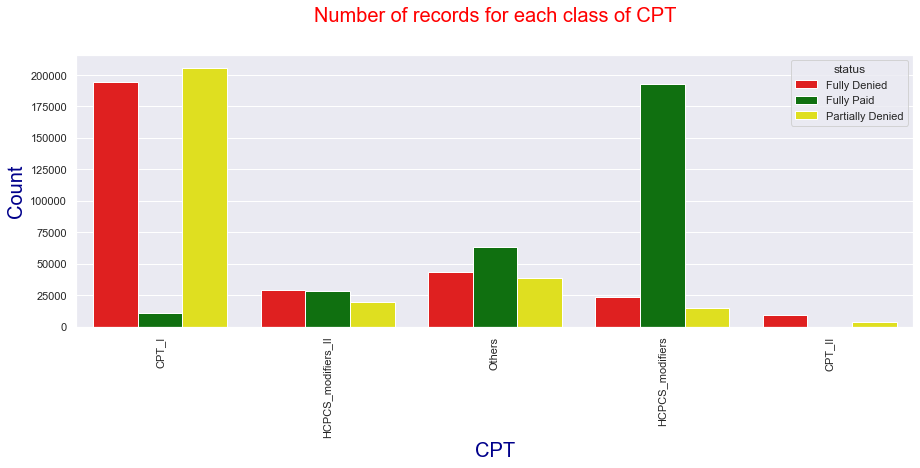

In [95]:
feature = 'CPT'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status',palette =palette )
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.xticks(rotation = 90)
plt.show()

In [96]:
data = data[data.procedure_code.notnull()]

In [97]:
data

,subscriber_id,city,county,provider_id,provider_type,provider_type2,claim_id,claim_sequence,line_of_business,age,...,copay,coinsurance,rejection_code,rejection_reason,network_indicator2,pre_auth_indicator,status,combination_id,ICD_10,CPT
0,s21835,B1,D1,NaN,Facility,HOSP,c7946,1,Medicaid,25,...,0.0,0.0,500,Disallowed amount,Participating,Not Required,Fully Denied,c7946_1,M00-M99,CPT_I
1,s21835,B1,D1,NaN,Facility,HOSP,c7946,2,Medicaid,25,...,0.0,0.0,500,Disallowed amount,Participating,Not Required,Fully Denied,c7946_2,M00-M99,HCPCS_modifiers_II
2,s21836,Others,Others,p349,Facility,HOSP,c7947,1,Medicaid,22,...,0.0,0.0,CDD,Claim is a duplicate of a previously submitted...,Participating,Not Required,Fully Denied,c7947_1,A00-B99,HCPCS_modifiers_II
3,s21837,B3,D3,NaN,Facility,HOSP,c7948,1,Medicaid,55,...,0.0,0.0,K03,APC/APG Pricing Never Pay,Participating,Not Required,Fully Denied,c7948_1,H60-H95,HCPCS_modifiers_II
4,s21838,B3,D4,NaN,Facility,HOSP,c7949,1,Medicaid,63,...,0.0,0.0,K02,APC/APG Pricing Stand Alone,Participating,Not Required,Fully Denied,c7949_1,I00-I95,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876466,s188497,B8,D9,p6400,Facility,HOSP,c275119,5,Medicaid,27,...,0.0,0.0,E01,EAPG Pricing Full Payment,NaN,Not Required,Partially Denied,c275119_5,M00-M99,Others
876467,s188497,B8,D9,p6400,Facility,HOSP,c275119,4,Medicaid,27,...,0.0,0.0,E01,EAPG Pricing Full Payment,NaN,Not Required,Partially Denied,c275119_4,M00-M99,CPT_I
876468,s188497,B8,D9,p6400,Facility,HOSP,c275119,1,Medicaid,27,...,0.0,0.0,E04,EAPG Pricing Packaged,NaN,Not Required,Partially Denied,c275119_1,M00-M99,CPT_I
876469,s188497,B8,D9,p6400,Facility,HOSP,c275119,3,Medicaid,27,...,0.0,0.0,E01,EAPG Pricing Full Payment,NaN,Not Required,Partially Denied,c275119_3,M00-M99,CPT_I


In [73]:
dict(d[d.procedure_code.notnull()].procedure_code.value_counts())

{'1967': 26,
 '740': 18,
 '810': 16,
 '1996': 14,
 '840': 14,
 '851': 13,
 '1CHKS': 12,
 '3641632': 11,
 '790': 11,
 '170': 10,
 '6880000': 10,
 '0001M': 8,
 '1BHKS': 8,
 '1AGKS': 8,
 '400': 7,
 '688000000': 6,
 '944': 6,
 '1922': 6,
 '670': 6,
 '1CHLS': 6,
 '1961': 6,
 '1CGLS': 5,
 '142': 5,
 'B4161BO': 5,
 '1172199': 5,
 '1966': 5,
 '6.88E+06': 5,
 '160': 5,
 '678000': 5,
 '1968': 5,
 '1BGKS': 4,
 '3AHKS': 4,
 'B4150BO': 4,
 '797': 4,
 '873': 4,
 '6.78E+08': 4,
 '1BGMS': 3,
 'A0428JR': 3,
 '952': 3,
 '1BFKS': 3,
 '902': 3,
 'A0425NJ': 3,
 'A0428JN': 3,
 '910': 3,
 '1214': 3,
 'A0428NJ': 3,
 'A0425JN': 3,
 '1AFKS': 3,
 '1630': 3,
 '1CGKU': 3,
 '860': 3,
 '1CGMS': 3,
 '2AFKS': 3,
 '1480': 3,
 '6780000': 3,
 '1CGKT': 3,
 '1830': 3,
 '1CHKT': 3,
 'A0425JR': 3,
 'A0425RJ': 3,
 'A0428RJ': 3,
 '1402': 3,
 '1CGKS': 2,
 '1CHKU': 2,
 '6.78E+05': 2,
 '832': 2,
 'AAA00': 2,
 '59400UB': 2,
 '1AHKT': 2,
 '3AGMS': 2,
 '1810': 2,
 '67800000': 2,
 '120': 2,
 '679000': 2,
 '199123': 2,
 '215': 2,
 '67

In [71]:
data.CPT.unique().shape

(16,)

In [37]:
data.columns

Index(['member_id', 'subscriber_id', 'city', 'county', 'provider_id',
       'provider_type', 'provider_type2', 'claim_id', 'claim_sequence',
       'line_of_business', 'age', 'gender', 'claim_sub_type',
       'network_indicator1', 'place_of_service', 'procedure_code',
       'diagnosis_code', 'claim_from_date', 'claim_to_date', 'amount_on_claim',
       'amount_considered', 'amount_allowed', 'amount_dis_allowed',
       'amount_paid', 'dedcutible', 'copay', 'coinsurance', 'rejection_code',
       'rejection_reason', 'network_indicator2', 'pre_auth_indicator',
       'status', 'combination_id', 'ICD_10', 'CPT'],
      dtype='object')

In [38]:
date = data.claim_to_date

In [39]:
data[['claim_from_date','claim_to_date']]

,claim_from_date,claim_to_date
0,1/3/2017,1/3/2017
1,1/5/2017,1/5/2017
2,7/3/2017,7/3/2017
3,1/7/2017,1/7/2017
4,1/30/2017,1/30/2017
...,...,...
876466,2017-01-02 00:00:00,2017-01-02 00:00:00
876467,2017-01-02 00:00:00,2017-01-02 00:00:00
876468,2017-01-02 00:00:00,2017-01-02 00:00:00
876469,2017-01-02 00:00:00,2017-01-02 00:00:00


<h1 style = "color : darkblue">Service Period</h1>
<h3 style = "color : green">How much time the service has been rendered. It will be obtained by calculating the diff between claim_from_date and claim_to_date</h3>

In [40]:
from dateutil import parser

In [41]:
data['claim_from_date'] =data['claim_from_date'].apply(lambda x : parser.parse(x)) 
data['claim_to_date'] =data['claim_to_date'].apply(lambda x : parser.parse(x)) 

In [42]:
data['serive_period'] = (data['claim_to_date']-data['claim_from_date']).dt.days+1

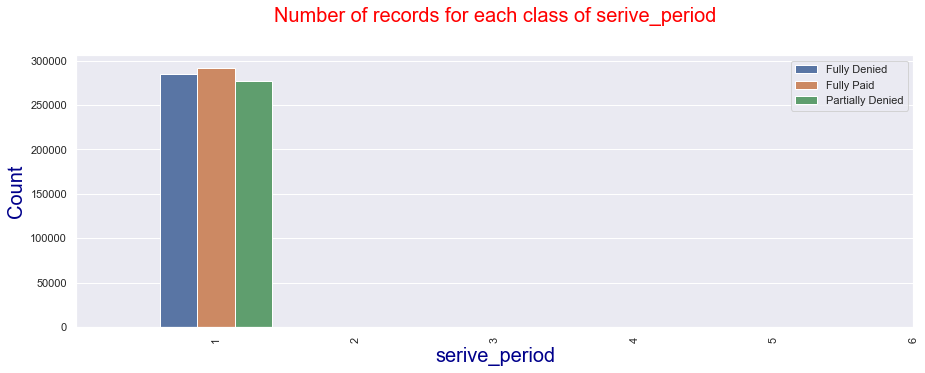

In [46]:
feature = 'serive_period'
plt.figure(figsize =(15,5))
sns.countplot(x =feature ,data=data,hue='status')
plt.xlabel(feature, color = 'darkblue', fontsize =20)
plt.ylabel('Count', color = 'darkblue', fontsize =20)
plt.title(f'Number of records for each class of {feature}', color='red',fontsize =20,y =1.1)
plt.xticks(rotation = 90)
plt.legend(loc='upper right')
plt.xlim(-1,5)
plt.show()

In [48]:
data.columns

Index(['member_id', 'subscriber_id', 'city', 'county', 'provider_id',
       'provider_type', 'provider_type2', 'claim_id', 'claim_sequence',
       'line_of_business', 'age', 'gender', 'claim_sub_type',
       'network_indicator1', 'place_of_service', 'procedure_code',
       'diagnosis_code', 'claim_from_date', 'claim_to_date', 'amount_on_claim',
       'amount_considered', 'amount_allowed', 'amount_dis_allowed',
       'amount_paid', 'dedcutible', 'copay', 'coinsurance', 'rejection_code',
       'rejection_reason', 'network_indicator2', 'pre_auth_indicator',
       'status', 'combination_id', 'ICD_10', 'CPT', 'serive_period'],
      dtype='object')

In [101]:
categorical_features = ['provider_type','provider_type2','line_of_business','age','gender','claim_sub_type',
                        'network_indicator1','place_of_service','ICD_10','CPT']

numerical_features    = ['amount_on_claim',]

target_feature        = ['status']


In [102]:
data_cleaned = data[categorical_features+numerical_features+target_feature]

In [103]:
data_cleaned.to_csv('data_cleaned.csv',index=False)

In [104]:
data_cleaned = pd.read_csv('data_cleaned.csv')

In [105]:
data_cleaned.columns

Index(['provider_type', 'provider_type2', 'line_of_business', 'age', 'gender',
       'claim_sub_type', 'network_indicator1', 'place_of_service', 'ICD_10',
       'CPT', 'amount_on_claim', 'status'],
      dtype='object')

In [50]:
.

SyntaxError: invalid syntax (<ipython-input-50-a5d5b61aa8a6>, line 1)

In [ ]:
temp = data['status'].value_counts()
plt.figure(figsize=(10,5))
labels = temp.index
sizes = temp
colors = ['lightskyblue','yellowgreen', 'lightcoral', 'mediumpurple', 'silver','burlywood', 'salmon',  'chocolate', 'orchid']
explode = [0,0]
 
# Plot
plt.pie(sizes, explode=None, labels=['']*len(labels), colors=colors,
        autopct='%1.1f%%', shadow=True, startangle = 110, counterclock = False)
plt.title('Claim Types Proportion', bbox={'facecolor':'0.8', 'pad':5}, y =1.05)
plt.legend(labels, loc="lower right")
plt.axis('equal')
plt.show()

In [ ]:
occupation_counts = (data.groupby(['provider_type'])['status']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status'))

plt.subplots(figsize=(8,4))
p = sns.barplot(x="provider_type", y="percentage", hue="status", data=occupation_counts, palette= palette)



**Inference:** It is clear that when the provider_type is F(Facility) there are more chances of getting paid fully than P(Practitioner)

In [ ]:
occupation_counts = (data.groupby('provider_type2')['status']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status'))

plt.subplots(figsize=(12,6))

p = sns.barplot(x="provider_type2", y="percentage", hue="status", data=occupation_counts, palette= palette)
plt.xticks(rotation = 90)
plt.show()


**Inference** : 90% of HHA (Home Health Aid) claims are fully paid. There seems to be a great correlation between the denial and type of claim

In [ ]:
temp = data['gender'].value_counts()
plt.figure(figsize=(10,5))
labels = temp.index
sizes = temp
colors = ['lightskyblue','yellowgreen', 'lightcoral', 'mediumpurple', 'silver','burlywood', 'salmon',  'chocolate', 'orchid']
explode = [0,0]
 
# Plot
plt.pie(sizes, explode=explode, labels=['']*len(labels), colors=colors,
        autopct='%1.1f%%', shadow=True, startangle = 110, counterclock = False)
plt.title('Applicants Gender Proportions', bbox={'facecolor':'0.8', 'pad':5}, y =1.05)
plt.legend(labels, loc="lower right")
plt.axis('equal')
plt.show()

In [ ]:
plt.subplots(figsize=(10,5))
sns.kdeplot(data.age[data.status == 'FD'], legend = False)
sns.kdeplot(data.age[data.status == 'PD'], legend = False)
sns.kdeplot(data.age[data.status == 'FP'], legend = False)
plt.title("Age vs Status (FD-Blue; PD-Orange; FP-Green)")
plt.show()

**Inference** : Higher the age, higher the probability of getting an FP

In [ ]:
occupation_counts = (data.groupby(['line_of_business'])['status']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index": "line_of_business", "ICD_10": "percentage"}))

plt.subplots(figsize=(12,6))
p = sns.barplot(x="line_of_business", y="percentage", hue = 'status', data=occupation_counts, palette= palette)
plt.show()


**Inference** Medicaid claims have better chances of getting fully paid than others

In [ ]:
occupation_counts

In [ ]:
occupation_counts = (data.ICD_10
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index": "ICD_10", "ICD_10": "percentage"})
                     .sort_values("ICD_10")
                     .reset_index()
                     .drop('index', axis = 1))

plt.subplots(figsize=(14,8))
p = sns.barplot(x="ICD_10", y="percentage", data=occupation_counts)
plt.xticks(rotation = 90)

for index, row in occupation_counts.iterrows():
     p.text(index,row.percentage, round(row.percentage,2), color='black', ha="center")

**Inference**: R00-R99 & Z00-Z99 ICD claims are mostly denied

In [ ]:
plt.subplots(figsize=(12,8))
temp = data.groupby('ICD_10')['amount_dis_allowed'].sum().reset_index()
temp['percentage'] = temp.amount_dis_allowed/sum(temp.amount_dis_allowed)*100
p = sns.barplot(temp.ICD_10, temp.percentage)
plt.xticks(rotation = 90)
plt.xlabel('ICD_10_codes')
plt.ylabel('percentage')
plt.title('% of amount Denied per each ICD Code.')

for index, row in temp.iterrows():
    p.text(row.name,row.percentage, round(row.percentage,2), color='black', ha="center")

In [ ]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
k = fully_denied['rejection_code'].value_counts()
t = fully_denied[ fully_denied['rejection_code'].isin(k[:21].index)]
sns.countplot(x="rejection_code", data=t, order=t.rejection_code.value_counts().index)
plt.title('Fully denied Data')
plt.show()

In [ ]:
claim_denial_reasons_top20 = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\Claim_Denial_Reason_Codes_Top20.csv")
claim_denial_reasons_top20.columns
rc_vc = pd.DataFrame(t.rejection_code.value_counts()).reset_index()
rc_vc.columns = ['Code', 'Value_Counts']

In [ ]:
(rc_vc.merge(claim_denial_reasons_top20, on='Code')).drop(columns=['Value_Counts'])

## Confusion Matrix - Multiclass model

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes=["Fully Denied", "Partially Denied", "Fully Paid"], title="",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix ' +title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [ ]:
best_model = np.array([[46300,   726,  9597],
       [  416, 54546,   804],
       [ 3881,   784, 47742]])
plt.figure()
plot_confusion_matrix(best_model, title = 'Random Forest')

                    precision    recall  f1-score   support

    Fully Denied       0.92      0.82      0.86     56623
    Partially Denied   0.97      0.98      0.98     55766
    Fully Paid         0.82      0.91      0.86     52407

     avg / total       0.90      0.90      0.90    164796

## Demo

In [ ]:
%matplotlib inline
import os
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import joblib
from matplotlib.colors import from_levels_and_colors

In [ ]:
header = {'Content-Type': 'application/json', 'Accept': 'application/json'}

In [ ]:
fully_denied = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\FDC_cleaned.csv")
partially_denied = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\PDC_cleaned.csv")
fully_paid = pd.read_csv("D:\DataSciencePOC's\Claim_Denial\data\FPC_cleaned.csv")

In [ ]:
fully_denied['combination_id'] = fully_denied['claim_id'].combine(fully_denied['claim_sequence'], lambda s1, s2: str(s1)+'_'+ str(s2))
partially_denied['combination_id'] = partially_denied['claim_id'].combine(partially_denied['claim_sequence'], lambda s1, s2: str(s1)+'_'+ str(s2))
fully_paid['combination_id'] = fully_paid['claim_id'].combine(fully_paid['claim_sequence'], lambda s1, s2: str(s1)+'_'+ str(s2))

In [ ]:
def get_member_data(MEM_ID):
    json_pd = partially_denied.loc[partially_denied.combination_id.isin(MEM_ID)].to_json()
    json_fd = fully_denied.loc[fully_denied.combination_id.isin(MEM_ID)].to_json()
    json_fp = fully_paid.loc[fully_paid.combination_id.isin(MEM_ID)].to_json()
    p_data = json.dumps({'partially_denied': json_pd,
             'fully_denied': json_fd,
             'fully_paid': json_fp})
    return p_data

In [ ]:
start_row = 0
end_row = 10
number_of_outputs = 10

In [ ]:
df = joblib.load(r"D:\DataSciencePOC's\Claim_Denial\data\combination_id_new.pkl")
df_ls = df[start_row : end_row]
try:
    p_data = get_member_data(df_ls)
    resp = requests.post("http://127.0.0.1:8002/predict", data = p_data, headers= header)
    pred_result = resp.json()
    pred_result_list = []
    #print(len(pred_result.items()))
    for i,j in pred_result.items():
        pred_result_list.append(j)
    pred_result_list = (np.array([pred_result_list])).reshape(len(pred_result_list),1)
    cmap, norm = from_levels_and_colors([0,1,2,3],['tab:green','tab:blue', 'tab:red'])
    img = plt.imshow(pred_result_list, interpolation='nearest', cmap=cmap, norm=norm, aspect='auto')
    plt.axis('off')
    for i, j in enumerate(pred_result_list):
            plt.text(0, i, "ClaimID:{} - No Denial".format(df_ls[i]) if j == 0  else ("ClaimID:{} - Possibility of Partial Denial".format(df_ls[i]) if j == 1 else "ClaimID:{} - Possibility of Full Denial".format(df_ls[i])) ,horizontalalignment="center")
    plt.tight_layout()
    start_row = end_row
    end_row = end_row + number_of_outputs
    #print(start_row, end_row)
except:
    print("EOF: Run the previous cell")

## Demo - Rejection Reason

In [ ]:
df_rcp = pd.read_csv(r"D:\DataSciencePOC's\Claim_Denial\data\rejection_codes_top10.csv")
def get_test_member_data_rcp(MEM_ID):
    json_rcp = df_rcp.loc[df_rcp.combination_id.isin(MEM_ID)].to_json()
    p_data = json.dumps({'rcp_df': json_rcp})
    return p_data
start_row = 0
end_row = 10
number_of_outputs = 10
rejection_reasons = {0 : '500', 1 : 'CDD', 2 : 'PFS', 3 : 'N01', 4 : 'PSS', 5 : 'X12', 6 : 'X33', 7 : 'E01', 8 : 'X08',
       9 : 'E04'}
df = joblib.load(r'data/combination_id_pickle.pkl')
df_ls = df.reset_index(drop=True)

In [ ]:
df_rcp.rejection_code.value_counts()

In [ ]:
import joblib
import json
import requests
#df_ls = df.reset_index(drop=True)
df_ls = df[start_row : end_row]
df_ls = df_ls.reset_index(drop=True)
rcp_data = get_test_member_data_rcp(df_ls)
resp = requests.post("http://127.0.0.1:8002/predict_rcp", data = rcp_data, headers= header)
pred_result = resp.json()
pred_result_list = []
#print(len(pred_result.items()))
for i,j in pred_result.items():
    pred_result_list.append(j)
pred_result_list = (np.array([pred_result_list])).reshape(len(pred_result_list),1)
cmap, norm = from_levels_and_colors([0,1,2,3,4,5,6,7,8,9,10],['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:olive', 'tab:brown', 'tab:gray', 
                                                              'tab:blue', 'tab:orange', 'tab:green'])
img = plt.imshow(pred_result_list, interpolation='nearest', cmap=cmap, norm=norm, aspect='auto')
plt.axis('off')
for i, j in enumerate(pred_result_list):
        plt.text(0, i, "ClaimID:{} - Rejection Reason {}".format(df_ls[i], rejection_reasons[j[0]]),horizontalalignment="center" )
plt.tight_layout()
start_row = end_row
end_row = end_row + number_of_outputs

In [ ]:
+4500*36